# Electricity Demand Forecasting


Time Series Modeling<br>
In this project I am exploring time series modeling for Electricity Demand Forecasting for the state of California.

In this notebook I investigate the use the the Facebook Prophet Model.  The original paper describing the model can be found here in the article <a href='https://peerj.com/preprints/3190/'>Forecasting At Scale</a>.  This notebook uses the weekly demand data for California electricity demand generated using the notebook EF_EDA_CleanSplitAgg.ipynb.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Module Import](#'import')<br>
2. [Data Import](#'read_data')<br>
    2A. [Data Split](#'data_split')<br>
3. [Modeling](#'modeling')<br>
4. [Walk Forward Validataion](#'wfvalidate')<br> 
    4A. [Walk Forward Validataion - Step 1](#'wfvalidate_step1')<br> 
    4B. [Walk Forward Validataion - Step 2](#'wfvalidate_step2')<br> 

----
### <a id='import'> 1. Module Import </a>

Import the modules used in this notebook.

----

In [27]:
import pandas as pd
import numpy as np

from fbprophet import Prophet
import matplotlib.pyplot as plt

----
###  <a id='read_data'>2. Data Import </a>

Read the data file created by the notebook EF_EDA_CleanSplitAgg.

----

In [28]:
elec_df = pd.read_csv('../data/big_demand_temp_train_by_week.csv', index_col=0)
elec_df.rename({'week_demand' : 'y'}, axis=1, inplace=True)
elec_df.index = pd.DatetimeIndex(elec_df.index)
elec_df['ds'] = elec_df.index
elec_df.head()

,y,CA_pop,la_high,sd_high,sj_high,sf_high,sac_high,f_high,DOW,ds
2015-07-06,5731095.0,13845790.0,82.21,73.78,79.45,70.22,93.37,95.83,0.0,2015-07-06
2015-07-13,6067423.0,13845790.0,89.36,84.02,90.26,83.36,98.36,99.60,0.0,2015-07-13
2015-07-20,6233738.0,13845790.0,87.65,80.50,88.28,78.39,98.36,98.03,0.0,2015-07-20
2015-07-27,6473305.0,13845790.0,86.55,78.30,95.77,82.20,106.58,106.40,0.0,2015-07-27
2015-08-03,6166221.0,13845790.0,91.70,81.52,83.53,70.89,95.65,95.56,0.0,2015-08-03


----

#### <a id='data_split'>2A. Data Split </a>

----

In [29]:
train_len = int(0.7 * elec_df.shape[0])
window_len = int(0.1 * elec_df.shape[0])

In [30]:
# Make the primary train/validation split
X_train = elec_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = elec_df.iloc[train_len:train_len+window_len, :]
X_walk2 = elec_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = elec_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

----

### <a id='modeling'>3. Modeling</a>

----

In [31]:
# Define the base model configuration
# In this file we're using the weekly data so the only seasonal component should be the year
m = Prophet(yearly_seasonality=True)

# Add the exogenous regressors
m.add_regressor('la_high')
m.add_regressor('sd_high')
m.add_regressor('f_high')
m.add_regressor('sj_high')
m.add_regressor('sf_high')
m.add_regressor('sac_high')
m.add_regressor('CA_pop')

# Train the model with the training dataset
m.fit(X_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
forecast = m.predict(X_walk1)
forecast.index = pd.DatetimeIndex(forecast['ds'])

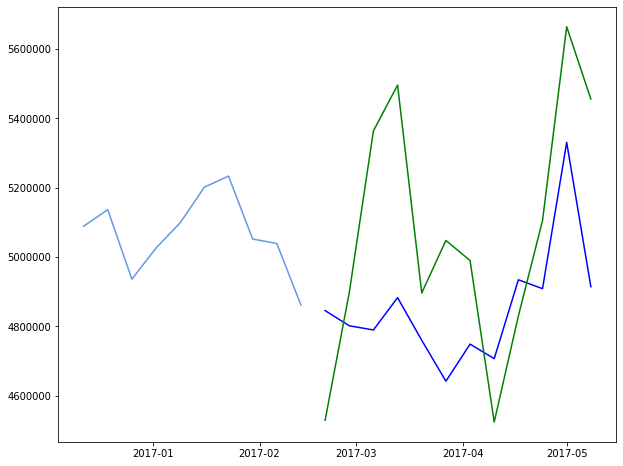

In [33]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk1.index[:20], X_walk1['y'].values[:20], c='b', label='Test Data')
plt.plot(X_train.index[-10:], X_train['y'].values[-10:], c='cornflowerblue', label='Training Data')
plt.plot(forecast.index[:20], forecast['yhat'].values[:20], c='green', label='Forecast')

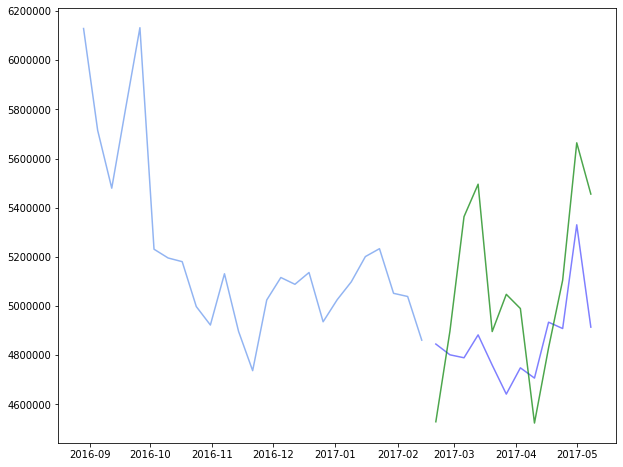

In [34]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk1.index, X_walk1['y'].values, c='b', alpha=0.5)
plt.plot(X_train.index[-25:], X_train['y'].values[-25:], c='cornflowerblue', alpha=0.7)
plt.plot(forecast.index, forecast['yhat'].values, c='green', alpha=0.7)

In [35]:
residuals = [abs(X_walk1.loc[x, 'y'] - forecast.loc[x, 'yhat'])/ \
             X_walk1.loc[x, 'y'] * 100 for x in forecast.index]
timestamps = [int(x.timestamp()) for x in forecast.index]
z = np.polyfit(timestamps, residuals, 1)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

(0, 20)

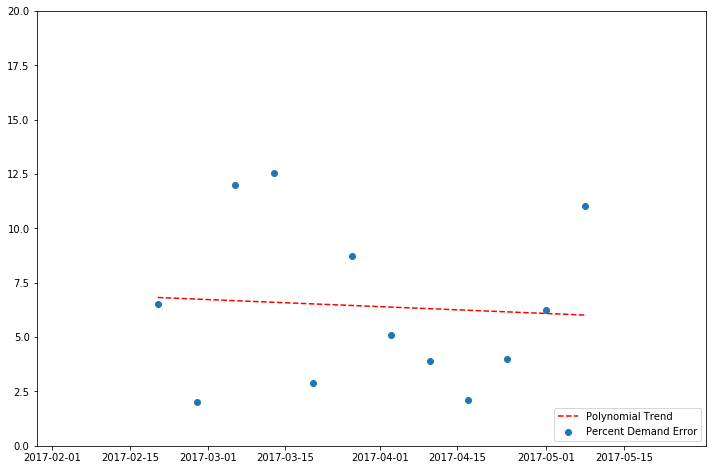

In [36]:
fig = plt.figure(figsize=[12,8])
plt.scatter(forecast.index, residuals, label='Percent Demand Error')
plt.plot(forecast.index, trend,"r--", label='Polynomial Trend')
plt.legend(loc='lower right')
plt.ylim(0, 20)

In [37]:
mape = np.mean(residuals[:3])
print(mape)

6.834796751319672


----

### <a id='wfvalidate'> 4. Walk Forward Validataion </a>

----

----

#### <a id='wfvalidate_step1'> 4A. Walk Forward Validataion - Step 1 </a>

----

In [38]:
X_train = X_train.append(X_walk1)

In [39]:
# The prophet model can only be trained once so we need to create a second instance.
m2 = Prophet(yearly_seasonality=True)

# Add regressors
m2.add_regressor('la_high')
m2.add_regressor('sd_high')
m2.add_regressor('f_high')
m2.add_regressor('sj_high')
m2.add_regressor('sf_high')
m2.add_regressor('sac_high')
m2.add_regressor('CA_pop')

# Train the model on the new data
m2.fit(X_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
forecast2 = m.predict(X_walk2)
forecast2.index = pd.DatetimeIndex(forecast2['ds'])

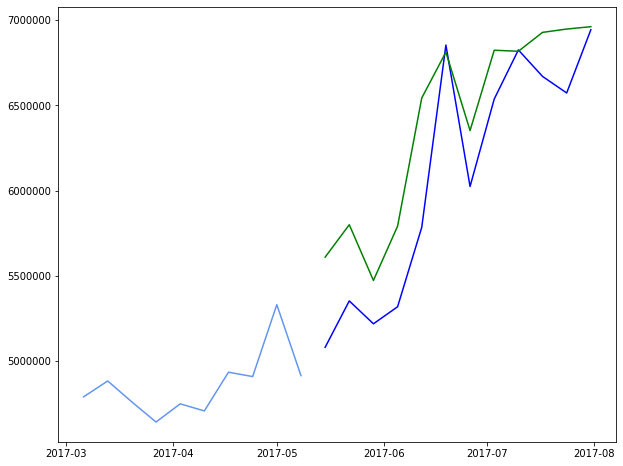

In [41]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk2.index[:20], X_walk2['y'].values[:20], c='b', label='Test Data')
plt.plot(X_train.index[-10:], X_train['y'].values[-10:], c='cornflowerblue', label='Training Data')
plt.plot(forecast2.index[:20], forecast2['yhat'].values[:20], c='green', label='Forecast')

In [42]:
residuals = [abs(X_walk2.loc[x, 'y'] - forecast2.loc[x, 'yhat'])/ \
             X_walk2.loc[x, 'y'] * 100 for x in forecast2.index]
timestamps = [int(x.timestamp()) for x in forecast.index]
z = np.polyfit(timestamps, residuals, 1)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

(0, 20)

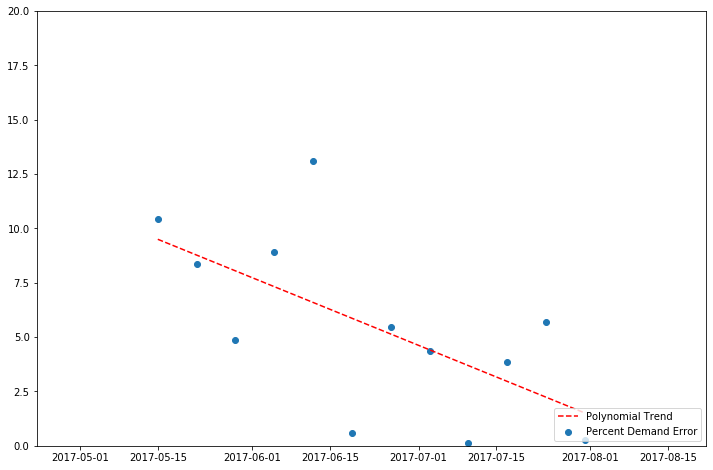

In [43]:
fig = plt.figure(figsize=[12,8])
plt.scatter(forecast2.index, residuals, label='Percent Demand Error')
plt.plot(forecast2.index, trend,"r--", label='Polynomial Trend')
plt.legend(loc='lower right')
plt.ylim(0, 20)

In [44]:
mape = np.mean(residuals[:4])
print(mape)

8.132339493743473


----

#### <a id='wfvalidate_step2'> 4B. Walk Forward Validataion - Step 2 </a>

----

In [46]:
X_train = X_train.append(X_walk2)

In [47]:
# Create a third instance
m3 = Prophet(yearly_seasonality=True)

# Add regressors
m3.add_regressor('la_high')
m3.add_regressor('sd_high')
m3.add_regressor('f_high')
m3.add_regressor('sj_high')
m3.add_regressor('sf_high')
m3.add_regressor('sac_high')
m3.add_regressor('CA_pop')

# Train the model with new data
m3.fit(X_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [48]:
forecast3 = m.predict(X_walk3)
forecast3.index = pd.DatetimeIndex(forecast3['ds'])

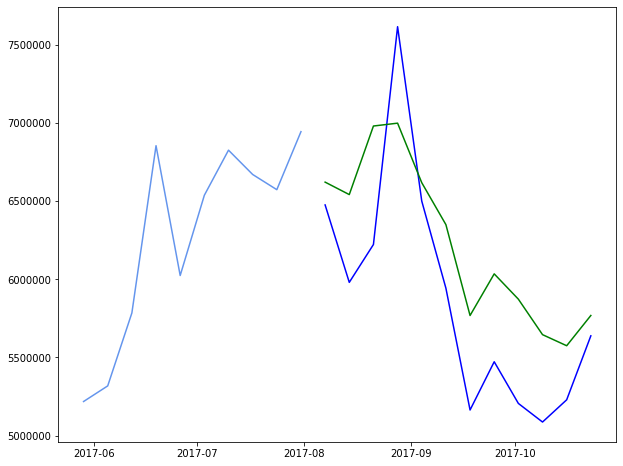

In [49]:
fig = plt.figure(figsize=[10,8])
plt.plot(X_walk3.index, X_walk3['y'].values, c='b', label='Test Data')
plt.plot(X_train.index[-10:], X_train['y'].values[-10:], c='cornflowerblue', label='Training Data')
plt.plot(forecast3.index, forecast3['yhat'].values, c='green', label='Forecast')

In [50]:
residuals = [abs(X_walk3.loc[x, 'y'] - forecast3.loc[x, 'yhat'])/ \
             X_walk3.loc[x, 'y'] * 100 for x in forecast3.index]
timestamps = [int(x.timestamp()) for x in forecast.index]
z = np.polyfit(timestamps, residuals, 1)
poly_trend = np.poly1d(z)
trend = [poly_trend(x) for x in timestamps]

(0, 20)

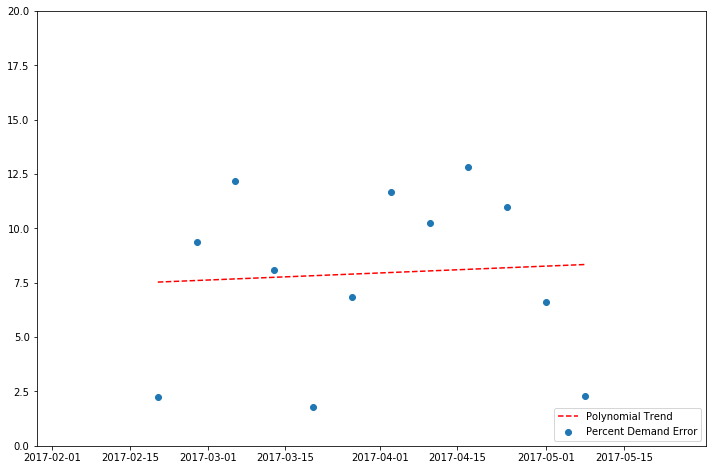

In [51]:
fig = plt.figure(figsize=[12,8])
plt.scatter(forecast.index, residuals, label='Percent Demand Error')
plt.plot(forecast.index, trend,"r--", label='Polynomial Trend')
plt.legend(loc='lower right')
plt.ylim(0, 20)

In [52]:
mape = np.mean(residuals[:3])
print(mape)

7.934864849733889
